In [3]:
from typing import List, Tuple
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from itertools import product

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784',as_frame = False)

X, target = mnist['data'], mnist['target']

y = target=='5'

In [2]:
# Splitting the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
# Exercise 7: Single decision tree
def check_fit(model, 
              X_train: np.ndarray, 
              X_test: np.ndarray,
              y_train: np.ndarray,
              y_test: np.ndarray) -> Tuple[float, float]:
    
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)

    diff = train_score - test_score

    return train_score, test_score, diff


def evaluate_model(model: any,
                    hyperparameters: dict,
                    X_train: np.ndarray,
                    X_test: np.ndarray,
                    y_train: np.ndarray,
                    y_test:np.array,
                    random_state: int = 1) -> dict:
    
    if model == DecisionTreeClassifier:
        clf = model(random_state = random_state,
                    **hyperparameters)
    else:
        clf = model(random_state = random_state,
                    **hyperparameters,
                    n_jobs=-1)
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    # Check if the model is fitting properly
    train_score, test_score, diff = check_fit(clf, X_train, X_test, y_train, y_test)


    return {**hyperparameters, 'Accuracy': accuracy, 'Train Score': train_score, 'Test Score': test_score, 'Difference': diff}


def grid_search(model: any,
                hyperparameters: List[dict],
                X_train: np.ndarray,
                X_test: np.ndarray,
                y_train: np.ndarray,
                y_test: np.ndarray) -> pd.DataFrame:
    
    param_combi = [dict(zip(hyperparameters.keys(), values)) 
                   for values in product(*hyperparameters.values())]
    
    results = []
    for params in param_combi:
        try:
            result = evaluate_model(model, params, X_train, X_test, y_train, y_test)
            results.append(result)
        except Exception as e:
            print(f"Error with parameters {params}: {e}")

    df_results = pd.DataFrame(results)

    return df_results


def sort_valid_trainning(df_results: pd.DataFrame) -> pd.DataFrame:
    good_fit_mask = (df_results['Difference'] < 0.1) & (df_results['Train Score'] > 0.8)

    # Split DataFrame into well-fitting and poor-fitting models
    well_fitting = df_results[good_fit_mask].sort_values('Accuracy', ascending=False)
    
    if well_fitting.empty:
        print("No well fitting models found")
        return df_results
    return well_fitting


In [45]:
def main():
    param_grid = {
    'max_depth': [13, 14, 15, 16, 17],       
    'min_samples_split': [2, 3, 4, 5, 6],
    'min_samples_leaf': [1, 2, 3, 4, 5]
    }

    df_results = grid_search(DecisionTreeClassifier, param_grid, X_train, X_test, y_train, y_test)
    well_fitting = sort_valid_trainning(df_results)
    display(well_fitting)


if __name__ == "__main__":
    main()

,max_depth,min_samples_split,min_samples_leaf,Accuracy,Train Score,Test Score,Difference
55,15,3,1,0.979786,0.994589,0.979786,0.014804
66,15,5,2,0.979643,0.993857,0.979643,0.014214
65,15,5,1,0.979643,0.994286,0.979643,0.014643
121,17,6,2,0.979357,0.995339,0.979357,0.015982
71,15,6,2,0.979357,0.993589,0.979357,0.014232
...,...,...,...,...,...,...,...
117,17,5,3,0.976786,0.994929,0.976786,0.018143
107,17,3,3,0.976786,0.994929,0.976786,0.018143
122,17,6,3,0.976786,0.994929,0.976786,0.018143
112,17,4,3,0.976786,0.994929,0.976786,0.018143


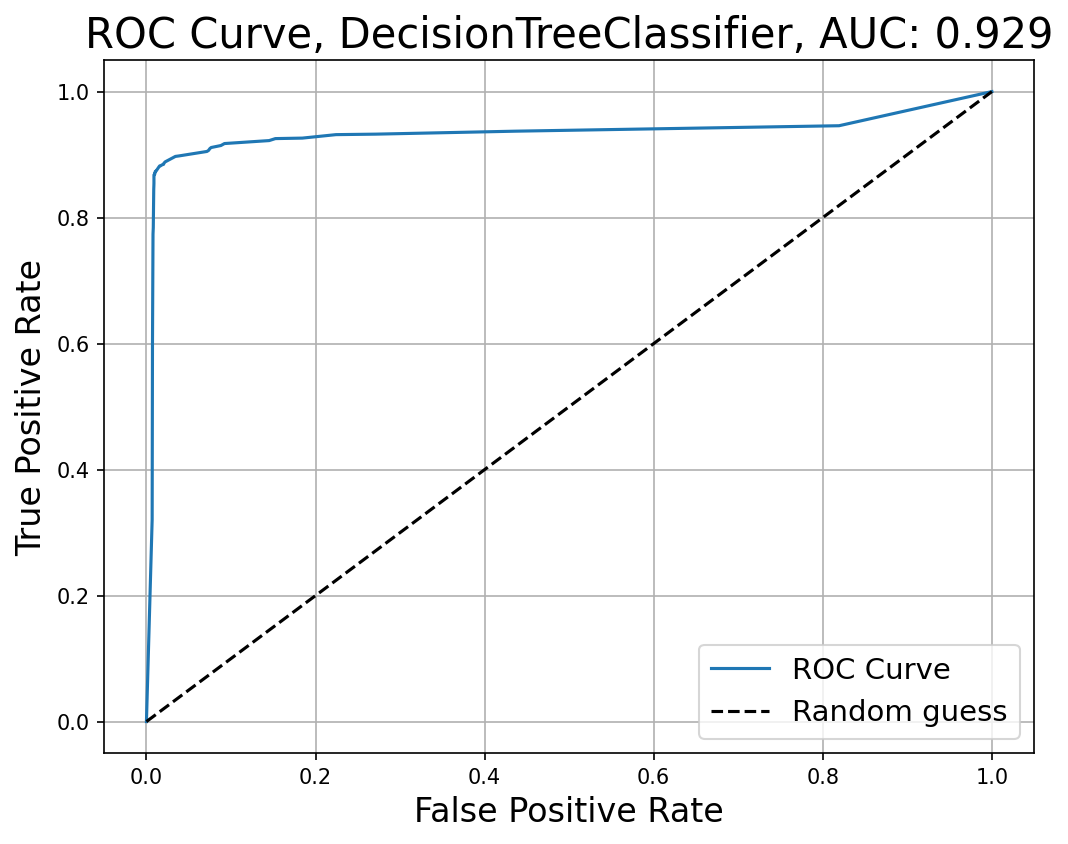

In [46]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

depth = 15
split = 3 
leaf = 1

clf_ex7_best = DecisionTreeClassifier(max_depth=depth, 
                                      min_samples_split=split, 
                                      min_samples_leaf=leaf, 
                                      random_state=1)

clf_ex7_best.fit(X_train, y_train)
y_pred = clf_ex7_best.predict(X_test)

def plot_roc_curve(model,y_test, y_pred):
    prob_pred = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, prob_pred)
    auc = roc_auc_score(y_test, y_pred)
    plt.figure(figsize=(8, 6), dpi = 150)
    plt.plot(fpr, tpr, label=f'ROC Curve')
    plt.plot([0, 1], [0, 1], 'k--',label='Random guess')
    plt.xlabel('False Positive Rate',fontsize = 16)
    plt.ylabel('True Positive Rate',fontsize = 16)
    plt.title('ROC Curve, {}, AUC: {:.3f}'.format(model.__class__.__name__, auc), fontsize=20)
    plt.grid()
    plt.legend(loc='lower right', fontsize=14)
    plt.show()

plot_roc_curve(clf_ex7_best, y_test, y_pred)

In [47]:
from sklearn.ensemble import RandomForestClassifier


def main():
    param_grid = {      
    'max_depth': [13, 14, 15, 16, 17], 
    'n_estimators': [100, 200, 300],       
    'min_samples_split': [2, 3, 4, 5, 6],
    'min_samples_leaf': [1, 2, 3, 4, 5]
    }

    df_results = grid_search(RandomForestClassifier, param_grid, X_train, X_test, y_train, y_test)
    well_fitting = sort_valid_trainning(df_results)
    # well_fitting.to_csv('well_fitting_random_forest.csv')
    display(well_fitting)

if __name__ == "__main__":
    main()

,max_depth,n_estimators,min_samples_split,min_samples_leaf,Accuracy,Train Score,Test Score,Difference
290,16,300,5,1,0.989500,0.998607,0.989500,0.009107
351,17,300,2,2,0.989429,0.998732,0.989429,0.009304
356,17,300,3,2,0.989429,0.998732,0.989429,0.009304
361,17,300,4,2,0.989429,0.998732,0.989429,0.009304
335,17,200,4,1,0.989357,0.999357,0.989357,0.010000
...,...,...,...,...,...,...,...,...
69,13,300,5,5,0.985786,0.992036,0.985786,0.006250
64,13,300,4,5,0.985786,0.992036,0.985786,0.006250
74,13,300,6,5,0.985786,0.992036,0.985786,0.006250
59,13,300,3,5,0.985786,0.992036,0.985786,0.006250


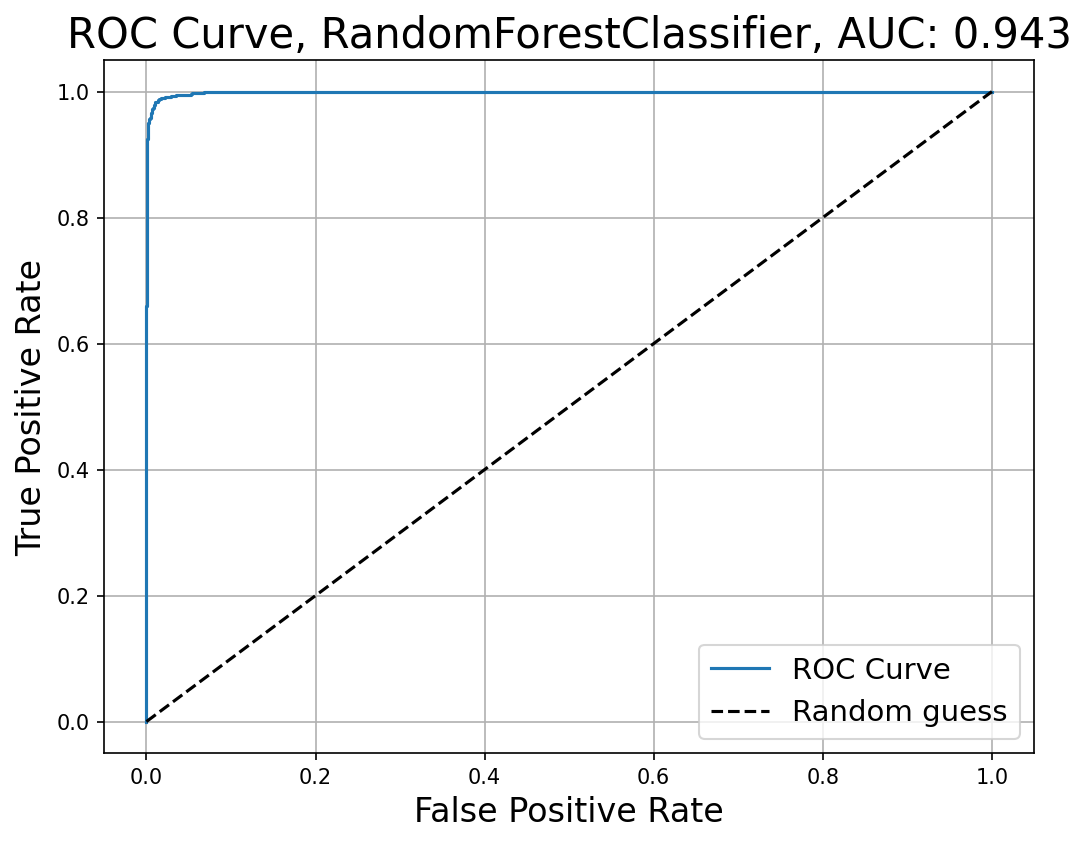

In [48]:
depth = 16
n_estimators = 300
split = 5
leaf = 1

clf_ex8_best = RandomForestClassifier(max_depth=depth,
                                      n_estimators=n_estimators,
                                      min_samples_split=split,
                                      min_samples_leaf=leaf,
                                      random_state=1,
                                      n_jobs=-1)

clf_ex8_best.fit(X_train, y_train)
y_pred = clf_ex8_best.predict(X_test)

plot_roc_curve(clf_ex8_best, y_test, y_pred)

In [42]:
from xgboost import XGBClassifier

def main():
    model = XGBClassifier
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [13, 14, 15, 16, 17],
        'max_leaves': [1, 2, 3, 4, 5],
        'learning_rate': [0.05]
    }

    df_results = grid_search(model, param_grid, X_train, X_test, y_train, y_test)
    well_fitting = sort_valid_trainning(df_results)
    well_fitting.to_csv('well_fitting_xgboost.csv')
    display(well_fitting)

if __name__ == "__main__":
    main()

,n_estimators,max_depth,max_leaves,learning_rate,Accuracy,Train Score,Test Score,Difference
74,300,17,5,0.05,0.982857,0.984661,0.982857,0.001804
69,300,16,5,0.05,0.982857,0.984661,0.982857,0.001804
59,300,14,5,0.05,0.982857,0.984661,0.982857,0.001804
64,300,15,5,0.05,0.982857,0.984661,0.982857,0.001804
54,300,13,5,0.05,0.982857,0.984661,0.982857,0.001804
...,...,...,...,...,...,...,...,...
10,100,15,1,0.05,0.909071,0.910000,0.909071,0.000929
20,100,17,1,0.05,0.909071,0.910000,0.909071,0.000929
50,300,13,1,0.05,0.909071,0.910000,0.909071,0.000929
60,300,15,1,0.05,0.909071,0.910000,0.909071,0.000929


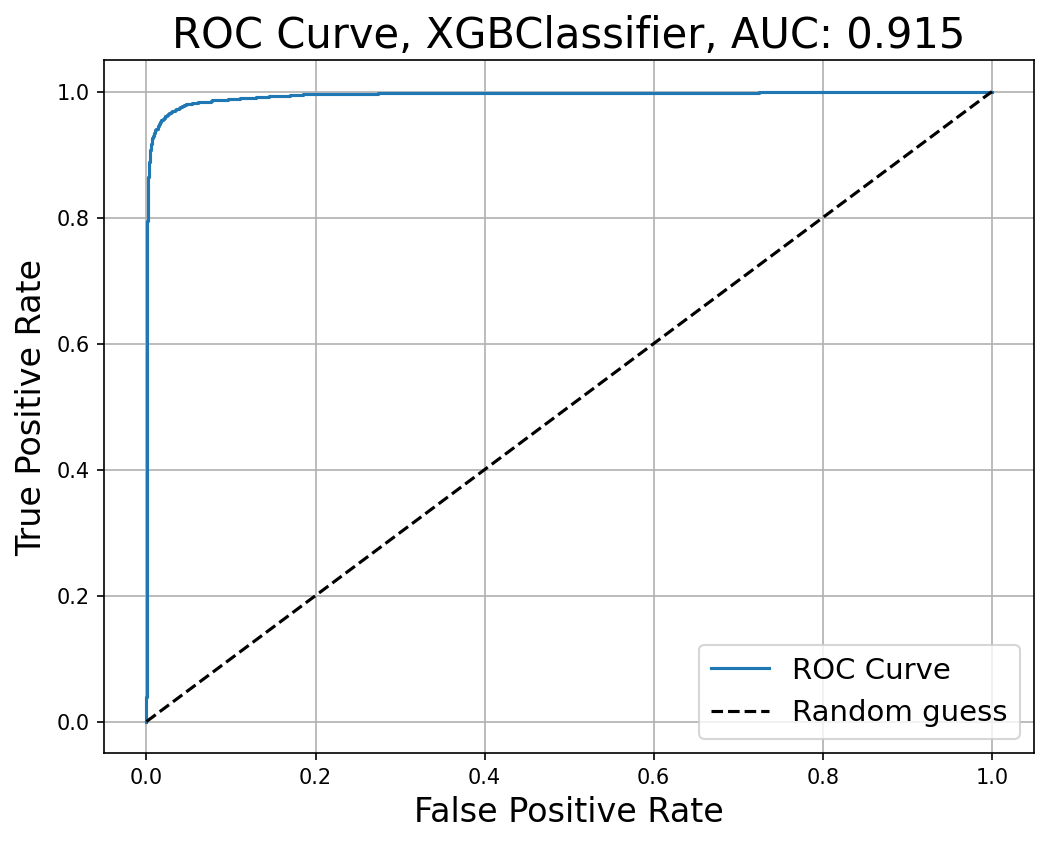

In [43]:
depth = 17
n_estimators = 300
max_leaves = 5
learning_rate = 0.05

clf_ex9_best = XGBClassifier(max_depth=depth,
                                n_estimators=n_estimators,
                                max_leaves=max_leaves,
                                learning_rate=learning_rate,
                                random_state=1,
                                n_jobs=-1)

clf_ex9_best.fit(X_train, y_train)
y_pred = clf_ex9_best.predict(X_test)

plot_roc_curve(clf_ex9_best, y_test, y_pred)